# gssnng
Gene Set Scoring on the Nearest Neighbor Graph (gssnng) for Single Cell RNA-seq (scRNA-seq)

Works with AnnData objects stored as h5ad files. The function takes values from adata.X and records scores in adata.obs

The method works by sampling nearest neighbors for each cell, creating essentially a mini-pseudobulk expression profile, and performing single sample gene set scoring.  This gives each cell a score and preserves gradients across clusters.

https://github.com/IlyaLab/gssnng

Notebook author: David L Gibbs (david.gibbs@isbscience.org)

In [1]:
# first let's install the package from github
# and clone the repo for the example data
!pip install git+https://github.com/IlyaLab/gssnng
!git clone https://github.com/IlyaLab/gssnng

  Cloning https://github.com/IlyaLab/gssnng to /tmp/pip-req-build-lk58_nam
  Running command git clone --filter=blob:none --quiet https://github.com/IlyaLab/gssnng /tmp/pip-req-build-lk58_nam
  Resolved https://github.com/IlyaLab/gssnng to commit 277db34baee98056618de2740c4dbce64fa06a52
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.0 MB/s eta 0:00:00
  Created wheel for gssnng: filename=gssnng-0.5.0-py3-none-any.whl size=16399 sha256=eec15d8392eb1f4f8d17f59bc22f647f2649cf810bdcbdba96898b89a8bf4d70
  Stored in directory: /tmp/pip-ephem-wheel-cache-un0uqhqx/wheels/12/a6/0f/abc756a7905a15

In [62]:
from gssnng import score_cells, smoothing
import anndata
import numpy as np
import scanpy as sc
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## !! set up for google colab notebook !! ##
# these file paths point to the cloned repo from above #
gene_set_file = '/content/gssnng/gssnng/test/data/cibersort_lm22.gmt'

# ! Note the direction labels on the gene set names ! #
gene_set_names = ['B.cells.naive.up', 'B.cells.memory.up', 'Plasma.cells.up', 'T.cells.CD8.up', 'T.cells.CD4.naive.up', 'T.cells.CD4.memory.resting.up', 'T.cells.CD4.memory.activated.up', 'T.cells.follicular.helper.up', 'T.cells.regulatory..Tregs.up', 'T.cells.gamma.delta.up', 'NK.cells.resting.up', 'NK.cells.activated.up', 'Monocytes.up', 'Macrophages.M0.up', 'Macrophages.M1.up', 'Macrophages.M2.up', 'Dendritic.cells.resting.up', 'Dendritic.cells.activated.up', 'Mast.cells.resting.up', 'Mast.cells.activated.up', 'Eosinophils.up', 'Neutrophils.up']

In [4]:
# read in the 10x genomics example data set, same as used in the scanpy tuts
q = sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [87]:
# Then we'll produce a smoothed count matrix.
# Neighbors are sampled within the groupby parameter. Groups run in parallel, set cores parameter as appropriate.

q_list = smoothing.smooth_adata(adata=q,                    # AnnData object
                                  groupby='louvain',          # Will sample neighbors within this group, can take a list
                                  smooth_mode='connectivity', # Smooths matrix using distance weights from NN graph.
                                  recompute_neighbors=32,     # Rebuild nearest neighbor graph with groups, 0 turns off function
                                  cores=4)                    # Smoothed in parallel.

# The result is a list of AnnData objects with an entry for each groupby group, here each cluster.

... and dropping gssnng_groupby column...
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
**done**


In [89]:
 # q_list is a list of tuples
for qi in q_list:
    print(qi[0].obs.louvain[0])
    print(qi[1])  # the groupby-category names
    print("----")

Dendritic cells
Dendritic cells
----
CD8 T cells
CD8 T cells
----
FCGR3A+ Monocytes
FCGR3A+ Monocytes
----
B cells
B cells
----
Megakaryocytes
Megakaryocytes
----
NK cells
NK cells
----
CD4 T cells
CD4 T cells
----
CD14+ Monocytes
CD14+ Monocytes
----


The result is a list of AnnData objects with an entry for each groupby group, here each cluster.

In [90]:
# the name of the AnnData object
q_list[1][1]

'CD8 T cells'

In [91]:
# the AnnData object
q_list[1][0]

AnnData object with n_obs × n_vars = 316 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'gssnng_groupby'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'X_smooth'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [92]:
q[q.obs.louvain == 'CD8 T cells'].obs

,n_genes,percent_mito,n_counts,louvain,gssnng_groupby
index,,,,,
AAACGCACTGGTAC-1,782,0.016644,2163.0,CD8 T cells,CD8 T cells
AAACGCTGACCAGT-1,783,0.038161,2175.0,CD8 T cells,CD8 T cells
AAACGCTGGTTCTT-1,790,0.030973,2260.0,CD8 T cells,CD8 T cells
AAAGAGACGGACTT-1,458,0.023458,1151.0,CD8 T cells,CD8 T cells
AAATCCCTCCACAA-1,428,0.019895,955.0,CD8 T cells,CD8 T cells
...,...,...,...,...,...
TTCGTATGGATAGA-1,873,0.013131,1980.0,CD8 T cells,CD8 T cells
TTGCATTGAGCTAC-1,721,0.017588,1990.0,CD8 T cells,CD8 T cells
TTGCTAACACCAAC-1,788,0.021376,1918.0,CD8 T cells,CD8 T cells


In [93]:
q_tcells = q_list[1][0].copy()

In [94]:
q_tcells.obs

,n_genes,percent_mito,n_counts,louvain,gssnng_groupby
index,,,,,
AAACGCACTGGTAC-1,782,0.016644,2163.0,CD8 T cells,CD8 T cells
AAACGCTGACCAGT-1,783,0.038161,2175.0,CD8 T cells,CD8 T cells
AAACGCTGGTTCTT-1,790,0.030973,2260.0,CD8 T cells,CD8 T cells
AAAGAGACGGACTT-1,458,0.023458,1151.0,CD8 T cells,CD8 T cells
AAATCCCTCCACAA-1,428,0.019895,955.0,CD8 T cells,CD8 T cells
...,...,...,...,...,...
TTCGTATGGATAGA-1,873,0.013131,1980.0,CD8 T cells,CD8 T cells
TTGCATTGAGCTAC-1,721,0.017588,1990.0,CD8 T cells,CD8 T cells
TTGCTAACACCAAC-1,788,0.021376,1918.0,CD8 T cells,CD8 T cells


In [95]:
q_tcells.X[1:5,1:5]

array([[-0.27648515, -0.04273415, -0.4603669 , -0.5231178 ],
       [-0.27562705, -0.04569191, -0.46267566, -0.52448225],
       [-0.23244892, -0.04352009, -0.36709467, -0.37063497],
       [-0.2236184 , -0.04393958,  3.212301  , -0.3404437 ]],
      dtype=float32)

In [96]:
q_tcells.obsm['X_smooth'][1:5,1:5]

array([[-0.19636968, -0.04643329, -0.35782764, -0.07625866],
       [-0.1906654 , -0.04879647,  0.11424041,  0.22075397],
       [-0.06711337, -0.04669264,  0.03343431,  0.09068189],
       [-0.17287945, -0.04654046, -0.03668978, -0.03114599]])

In [98]:
np.where(q_tcells.var.index == 'C1orf86')

(array([3]),)

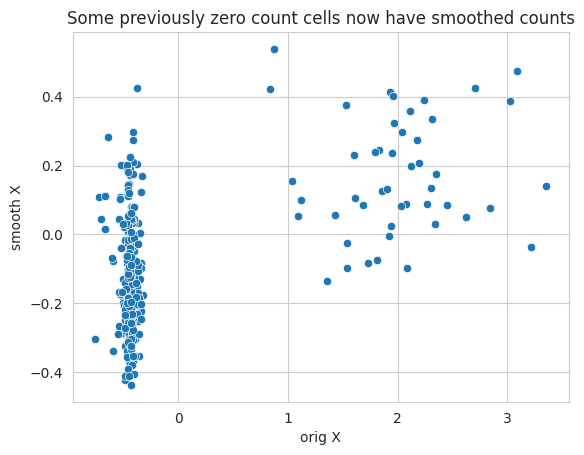

In [104]:
x1 = q[q.obs.louvain == 'CD8 T cells'].X
x2 = q_tcells.obsm['X_smooth']

#fig = sns.scatterplot(x=x1[:,1474], y=x2[:,1474])
fig = sns.scatterplot(x=x1[:,3], y=x2[:,3])

plt.xlabel("orig X")
plt.ylabel("smooth X")
plt.title('Some previously zero count cells now have smoothed counts')
plt.show(fig)

/users/dgibbs/miniconda3/envs/ScanpyEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


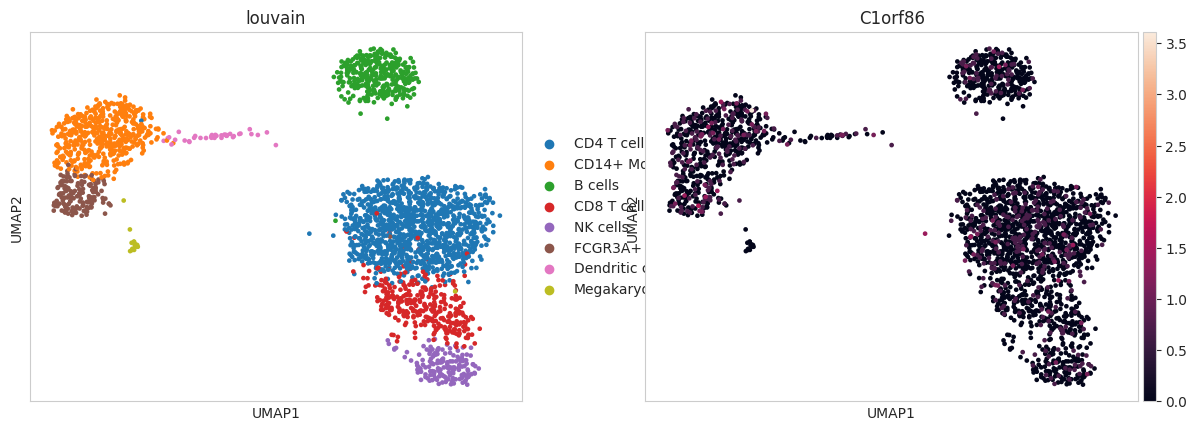

In [105]:
sc.pl.umap(q, color=['louvain','C1orf86'])

/users/dgibbs/miniconda3/envs/ScanpyEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


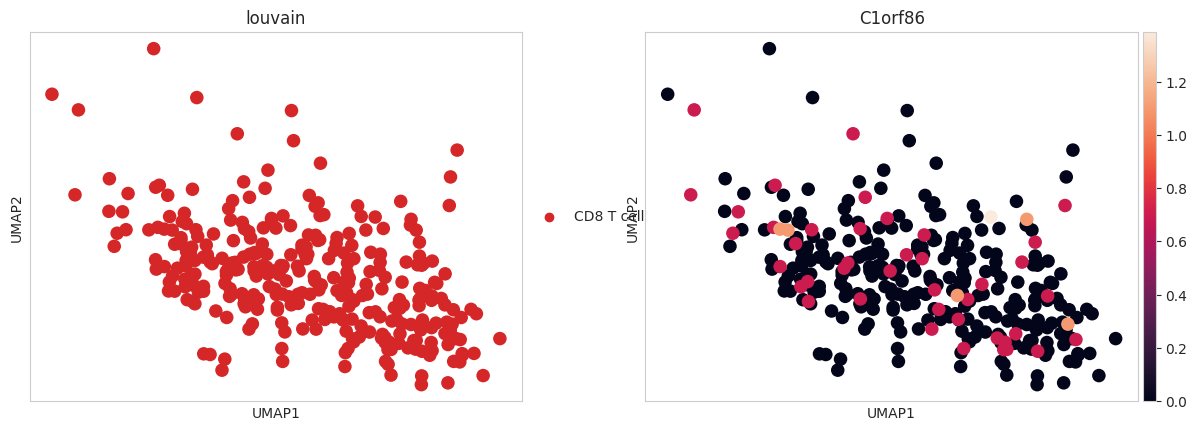

In [106]:
sc.pl.umap(q[q.obs.louvain == 'CD8 T cells'], color=['louvain','C1orf86'],)

In [107]:
q_tcells.X = q_tcells.obsm['X_smooth'].copy()

In [108]:
q_tcells.X[1:5,1:5]

array([[-0.19636968, -0.04643329, -0.35782764, -0.07625866],
       [-0.1906654 , -0.04879647,  0.11424041,  0.22075397],
       [-0.06711337, -0.04669264,  0.03343431,  0.09068189],
       [-0.17287945, -0.04654046, -0.03668978, -0.03114599]])

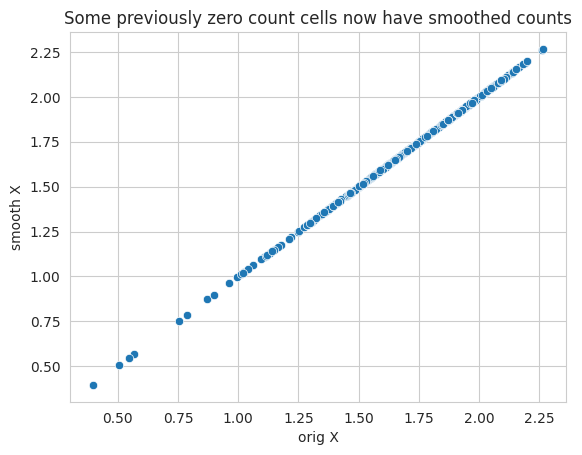

In [109]:
x1 = q_tcells.X
x2 = q_tcells.obsm['X_smooth']

fig = sns.scatterplot(y=x1[:,1474],
                      x=x2[:,1474])

plt.xlabel("orig X")
plt.ylabel("smooth X")
plt.title('Some previously zero count cells now have smoothed counts')
plt.show(fig)

/users/dgibbs/miniconda3/envs/ScanpyEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


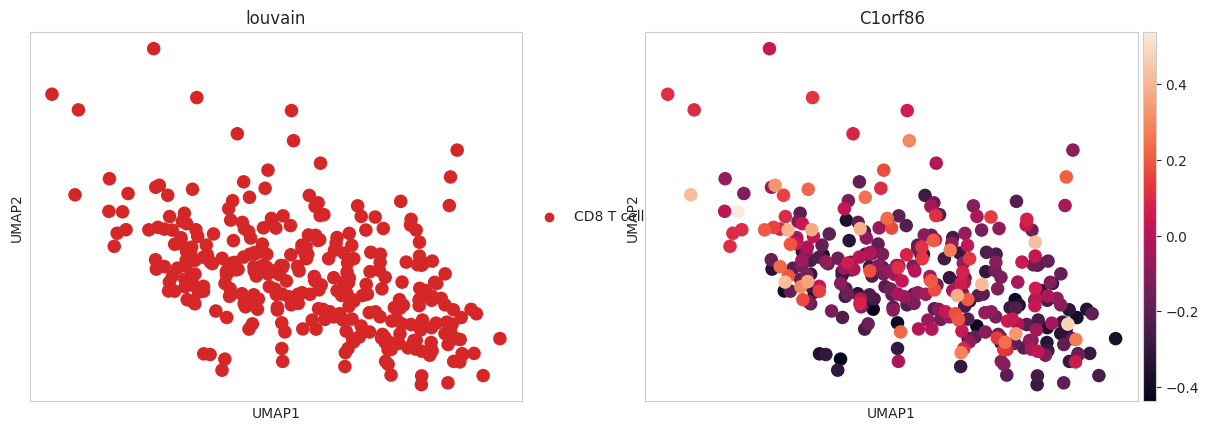

In [114]:
sc.pl.umap(q_tcells, color=['louvain','C1orf86'],use_raw=False)

/users/dgibbs/miniconda3/envs/ScanpyEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


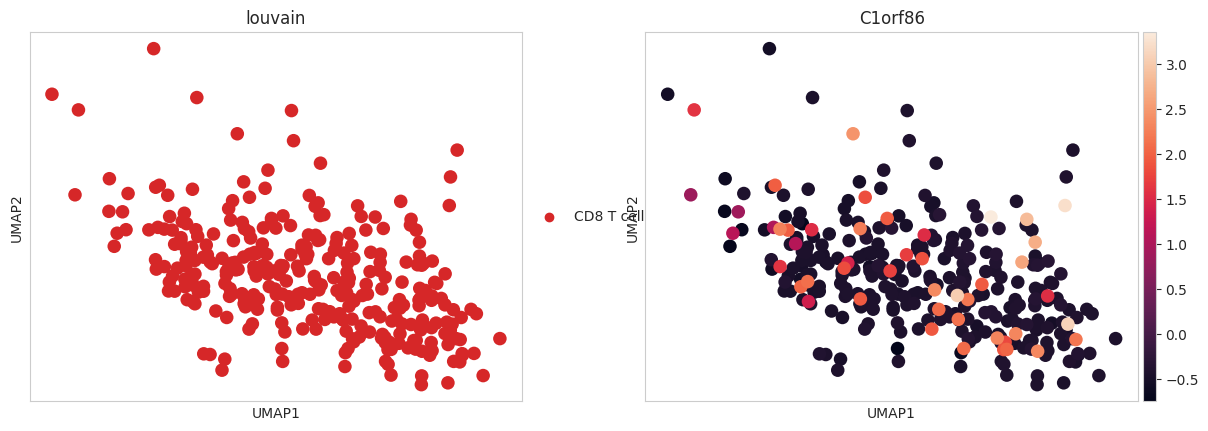

In [115]:
sc.pl.umap(q[q.obs.louvain == 'CD8 T cells'], color=['louvain','C1orf86'],use_raw=False)

In [112]:
 # q_list is a list of tuples
 for qi in q_list:
     print(qi[1])  # the groupby-category names

Dendritic cells
CD8 T cells
FCGR3A+ Monocytes
B cells
Megakaryocytes
NK cells
CD4 T cells
CD14+ Monocytes


In [138]:
q_new = anndata.concat([qi[0] for qi in q_list])

In [139]:
q_new

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'gssnng_groupby'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'X_smooth'

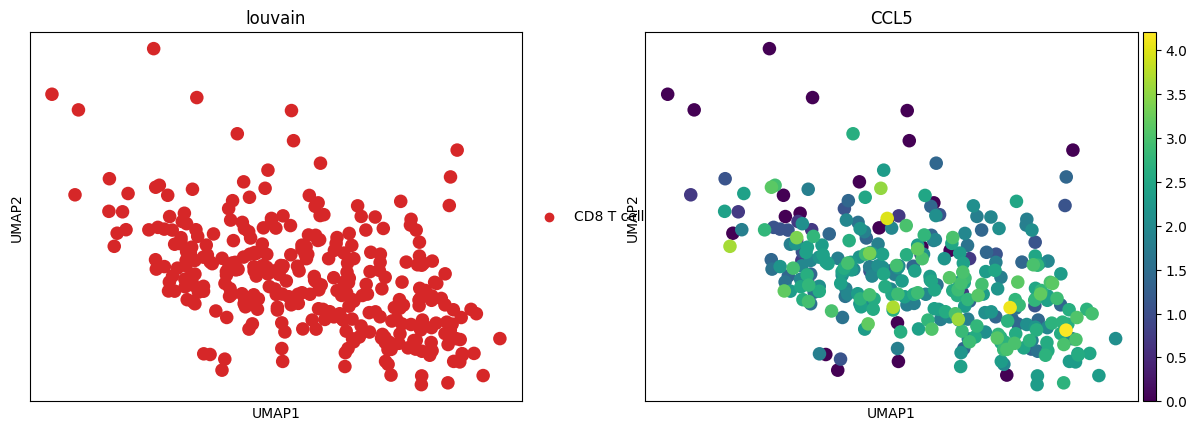

In [140]:
sc.pl.umap(q[q.obs.louvain == 'CD8 T cells'], color=['louvain','CCL5'])

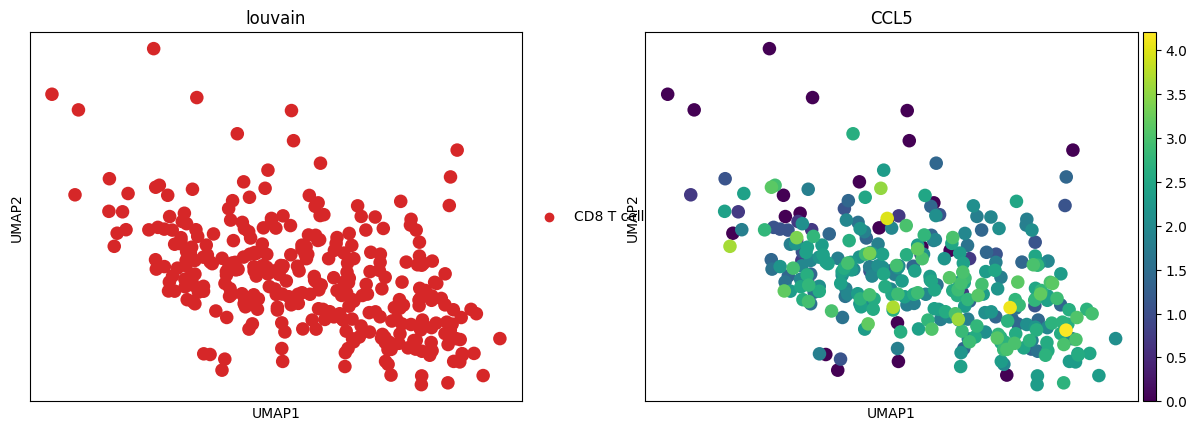

In [141]:
q_list[3][0].X = q_list[3][0].obsm['X_smooth'].copy()
sc.pl.umap(q_list[3][0], color=['louvain','CCL5'])

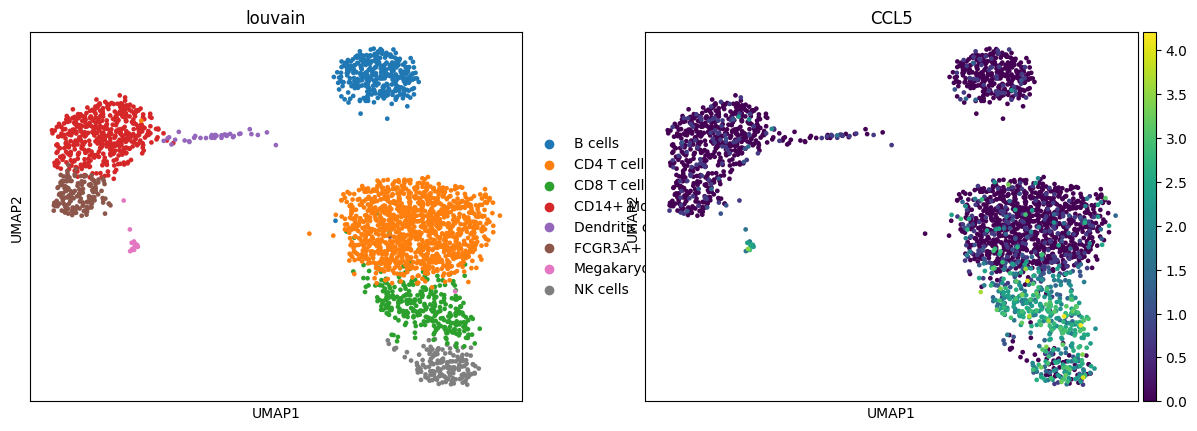

In [142]:
q_new.X = q_new.obsm['X_smooth'].copy()
sc.pl.umap(q_new, color=['louvain','CCL5'])

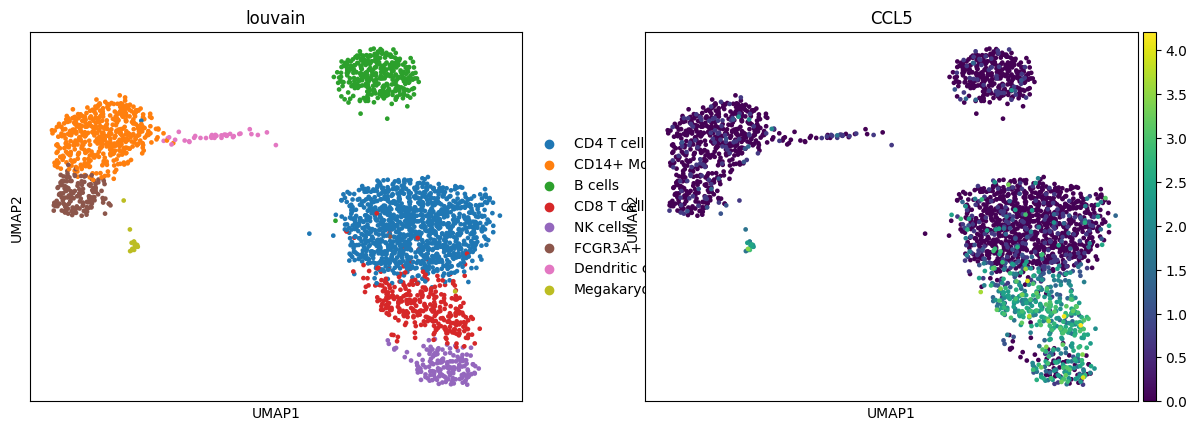

In [143]:
sc.pl.umap(q, color=['louvain','CCL5'])

In [144]:
q.var

,n_cells
index,
TNFRSF4,155
CPSF3L,202
ATAD3C,9
C1orf86,501
RER1,608
...,...
ICOSLG,34
SUMO3,570
SLC19A1,31


In [145]:
q.X.shape

(2638, 1838)

In [146]:
q_new.obsm['X_smooth'].shape

(2638, 1838)

In [147]:
numpy.where(q.var.index == 'CCL5')

(array([1474]),)

We can look at the expression.  Many of the cells that previously had zero counts will now have a small number of counts based on their neighbors.

In [20]:
x1 = q[q.obs.louvain == 'CD8 T cells'].X
x2 = q_list[3][0].obsm['X_smooth']

fig = sns.scatterplot(y=x1[:,1474],
                      x=x2[:,1474])

plt.xlabel("orig X")
plt.ylabel("smooth X")
plt.title('Some previously zero count cells now have smoothed counts')
plt.show(fig)

ValueError: All arrays must be of the same length

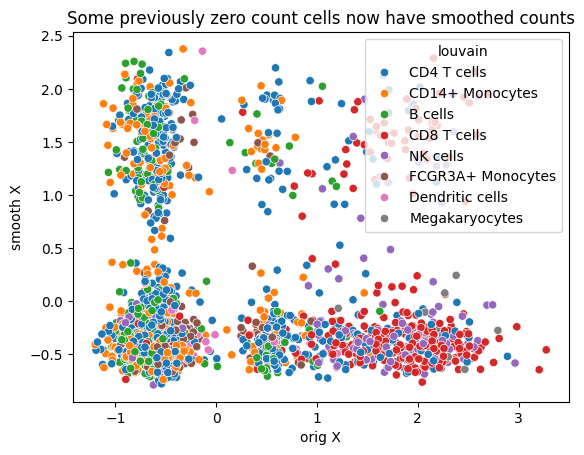

In [126]:
fig = sns.scatterplot(y=q_new.obsm['X_smooth'][:,1474],
                          x=q.X[:,1474],
                          hue=q.obs['louvain'])
plt.xlabel("orig X")
plt.ylabel("smooth X")
plt.title('Some previously zero count cells now have smoothed counts')
plt.show(fig)